# Part III: Advanced Applications

In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
import zfit
import numpy as np
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc')

import matplotlib.pyplot as plt
from scipy import stats
from Helpers import plot_fit

# pandas for data storage
import pandas as pd
# for the sWeighting we will use hepstats
from hepstats.splot import compute_sweights

zfit.settings.set_seed(1337)
gen = np.random.default_rng(seed=1337)

In this part we will discuss some more advanced applications of zfit: 
 - Pseudoexperiments
 - Background subtraction
 - Simultaneous fits
 - Disjoint fit ranges
 - Creating custom PDFs
 
## Setup

In order to create an example on the above applications, we will construct a background polluted signal sample, like the one we have been working with so far. In addition to a "mass" variable we will also add a second variable, which i arbitrarily choose to be called "lifetime". 

We already know how to set up a fit to determine parameters of interest in such a scenario, so i will be brief here. 

In [2]:
# create a dataset with some signal and some background with a control variable, the mass, 
# and a variable to unfold background and signal contributions

# gaussian signal in mass with exponential background
mass_sig = gen.normal(0.5, 0.1, size=(2000,))
mass_bkg = gen.exponential(0.4, size=(6000,))
mass_bkg = mass_bkg[mass_bkg <= 1]

# exponential signal in lifetime with gaussian background
ltime_sig = gen.exponential(1., size=(2000,))
ltime_bkg = gen.normal(2, 2, size=(20000,))
ltime_bkg = ltime_bkg[ltime_bkg>0][:mass_bkg.shape[0]]

data = pd.DataFrame({'mass': np.append(mass_sig, mass_bkg), 
                     'lifetime': np.append(ltime_sig, ltime_bkg)})

# create a zfit Observable for the fit
obs = zfit.Space('mass', limits=(0, 1))

# create the fit parameters for the mass fit
mu = zfit.Parameter('mu', 0.5, 0, 1)
sigma = zfit.Parameter('sigma', 0.1, 1e-3, 1)
slope = zfit.Parameter('slope', -2.5, -8, 0)

n_sig = zfit.Parameter('n_sig', 2000, 0, 9000)
n_bkg = zfit.Parameter('n_bkg', 6000, 0, 9000)

# create the pdfs and the model as sum 
signal_ = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, name='signal')
signal = signal_.create_extended(n_sig)
background_ = zfit.pdf.Exponential(obs=obs, lam=slope, name='background')
background = background_.create_extended(n_bkg)
model = zfit.pdf.SumPDF([signal, background], name='model')

# zfit data for the fitting (note that it takes the mass from the pandas dataframe because the observable space is called 'mass')
data_zfit = zfit.Data.from_pandas(df=data, obs=obs)

# loss as extended unbinned log likelihood
nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

In [3]:
# create the minimiser with strategy 1
minimiser = zfit.minimize.Minuit(mode=1)

# minimise the cost function and run hesse
# investigate the output of the result and plot the fit
result = minimiser.minimize(nll)
errors = result.hesse(name='minuit_hesse')
result

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.Data: Data obs=('mass',) shape=(7492, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  True   │    True     │      False       │ 8e-06 │         -1335.85 |  9991.937 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name      value  (rounded)    minuit_hesse    at limit
------  ------------------  --------------  ----------
n_sig              1966.88     +/-      94       False
n_bkg              5524.81     +/- 1.1e+02       False
mu                0.499487     +/-  0.0041       False
sigma             0.100853     +/-  0.0045       F

Histogram(Regular(50, 0, 1), storage=Double()) # Sum: 7492.0

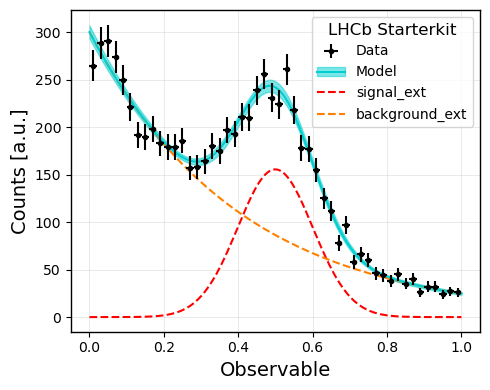

In [4]:
def eval_zfit_model(model: zfit.pdf.BasePDF, basis:np.ndarray, pars: np.ndarray)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    with zfit.param.set_values([n_sig, n_bkg, mu, sigma, slope], pars):
        pdf = model.pdf(basis) * (n_sig.numpy()+n_bkg.numpy())
    return pdf

# get the model pdf for the plot
basis = np.linspace(*obs.limit1d, 200)
model_np = model.pdf(basis).numpy() * (n_sig.numpy()+n_bkg.numpy())

# compute the uncertainties propagated to the model shape
mean_params = [result.params[p]['value'] for p in result.params.keys()]
covariance = result.covariance()
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)
smodels_np = np.std([eval_zfit_model(model, basis, pars) for pars in rnd_pars], ddof=1, axis=0)

# plot the fit 
plot_fit(data['mass'], basis, model_np, obs, smodel=smodels_np, zmodel=model)

## Pseudoexperiments

Pseudoexperiments, or commonly called "toys", are an extension of the bootstrapping idea we employed to propagate the uncertainties of our individual parameters to the model shape. Within LHCb they are frequently used to **valide the fit result** with respect to both central values and uncertainties and test for **goodness of fit**. 

To do this, one samples random numbers from the model-pdf we have fitted to the data and fit the model back to it. 
If we repeat this procedure often, we will obtain an ensemble of parameters, which can be used to validate if the fit is **unbiased** and if the **coverage** of the uncertainties from `hesse` are correct. 

One can extend this idea to make **systematic studies** by varying the model from which one samples and comparing parameters of interest in alternative models that are used for "fitting back". Another extension is to perform **goodness of fit** tests by estimating the distribution of $f\left(\min(-\log\mathcal{L})\right)$ and computing the p-value for the observed $\min(-\log\mathcal{L})^{\rm obs.}$. 

In order not to go overtime, i will show you how to create a setup for toy studies where you can sample from a model and fit this sampled "toy-data" back with `zfit`.

In [5]:
# create a "sampler" from a model pdf to generate the pseudodata with
# the option to create an extended sampler or to generate a specific
# amount of pseudo-data. The extended sampler will use the yield of
# the pdf and generate a sample whose number of entries are poisson
# distributed around the yield from the nominal fit. 

sampler = model.create_sampler(n='extended')

# resample some random data from the sampler (in place)
sampler.resample()

# create a cost function from the data stored in the sampler
# note that the sampler acts as a "zfit Data" object. 
toy_nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=sampler)

toy_result = minimiser.minimize(toy_nll)
toy_result.hesse(name='minuit_hesse')
toy_result

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.Data: Data obs=('mass',) shape=(7480, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.9e-07 │         -1304.14 |  10006.47 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    minuit_hesse    at limit
------  ------------------  --------------  ----------
n_sig              2021.17     +/-      92       False
n_bkg              5458.84     +/- 1.1e+02       False
mu                0.494174     +/-  0.0039       False
sigma            0.0995958     +/-  0.00

This process can be repeated in a loop or in multiple jobs with different sampling seed to obtain an ensemble of signal yields, for example. 

## Background Subtraction using sWeights

A common application for fits in LHCb is for statistical background subtraction. This follows the paper from [Pivk et al](https://arxiv.org/pdf/physics/0402083.pdf) and allows to statistically unfold background and signal distributions in variables that are **uncorrelated** to the control variable. 

We will use the $_s\mathcal{W}eight$ computation implemented in [`hepstats`](https://scikit-hep.org/hepstats/index.html). The $_s\mathcal{W}eights$ are determined for each measurement of the control variable $x$ as 
$$ w_i(x) = \frac{\sum_j^{N} V_{ij} f_j(x) }{\sum_k^{N} \mathcal{N}_k f_k(x) }, $$
where $N$ is the number of components in the model with $f_j(x)$ being the $j$-th component of the model with a yield of $\mathcal{N}_k$, and $V_{ij}$ is computed as
$$ V_{ij}^{-1} = \sum_{k}\frac{ f_i(x_k) f_j(x_k)}{\left(\sum_l^{N} \mathcal{N}_m f_m(x_k)\right)^2}. $$

We dont need to implemented this sum ourselves, as in the `hepstats` library it is already implemented. Lets take the previous fit to the mass variable to obtain a background subtracted lifetime distribution. 

In [6]:
# reset to the original fit results from the fit to data, currently 
# the parameters have the values from the toy fit
n_sig.set_value(result.params[n_sig]['value'])
mu.set_value(result.params[mu]['value'])
sigma.set_value(result.params[sigma]['value'])

n_bkg.set_value(result.params[n_bkg]['value'])
slope.set_value(result.params[slope]['value'])

# gives a dictionary containing the sWeights for all component yields
weights = compute_sweights(model, data_zfit)
print(type(weights))
print(f'Keys in weights dictionary', [kk for kk in weights.keys()])

# add the sWeights to the data tuple in pandas
data['sw_sig'] = weights[n_sig]
data['sw_bkg'] = weights[n_bkg]

<class 'dict'>
Keys in weights dictionary [<zfit.Parameter 'n_sig' floating=True value=1967>, <zfit.Parameter 'n_bkg' floating=True value=5525>]


## Application of $_s\mathcal{W}eights$

Popular usage of the background subtracted data is for illustration purposes, simulation calibration, or as input for a fit. It is important that after determining the $_s\mathcal{W}eights$, there must be no additional cuts applied to the dataset otherwise the weights lose their meaning. 

In the following the unfolded distributions of the background and signal lifetime are shown after the weighting and a fit to the data is performed to determine the lifetime. 

(0.0, 10.0)

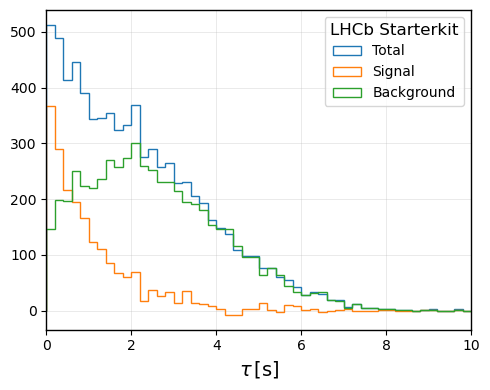

In [7]:
# construct histograms for the unweighted, signal, and background weighted data

plt.figure()
bins=np.linspace(0,10,51)
plt.hist(data['lifetime'], label='Total', bins = bins, histtype = 'step')
plt.hist(data['lifetime'], label='Signal', bins = bins, histtype = 'step', weights = data['sw_sig'])
plt.hist(data['lifetime'], label='Background', bins = bins, histtype = 'step', weights = data['sw_bkg'])
plt.legend(loc='best', title='LHCb Starterkit', title_fontsize=12)
plt.xlabel(r'$\tau\,[\mathrm{s}]$')
plt.xlim(0,10)

We can now perform a fit on lifetime with the signal $s\mathcal{W}eights$ extracted from the mass fit applied (orange plot above).

In [8]:
# observable for the lifetime space
obs_tau = zfit.Space(r'$\tau$ [s]', limits=(0, 10))

# lifetime parameter for signal
tau_sig = zfit.Parameter('tau_sig', -1, -2, 0)

# exponential model for lifetime
model_ltime = zfit.pdf.Exponential(obs=obs_tau, lam=tau_sig, name='exponential_lifetime')

# zfit data for the lifetime (including the weights!)
data_ltime = zfit.Data.from_numpy(obs=obs_tau, array=data['lifetime'].to_numpy(), 
                                  weights=data['sw_sig'].to_numpy())

# cost function to be minimised 
nll_ltime = zfit.loss.UnbinnedNLL(model=model_ltime, data=data_ltime)

# minimise the likelihood and run hesse
result_ltime = minimiser.minimize(nll_ltime)
result_ltime.hesse(name='minuit_hesse')
result_ltime

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.basic.Exponential'>  params=[tau_sig, tau_sig]] data=[<zfit.Data: Data obs=('$\\tau$ [s]',) shape=(7492, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 2.6e-07 │          2015.22 |  9999.373 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name       value  (rounded)    minuit_hesse    at limit
-------  ------------------  --------------  ----------
tau_sig           -0.975131     +/-   0.056       False

Plotting the result:

Histogram(Regular(50, 0, 10), storage=Double()) # Sum: 1966.8807633787417

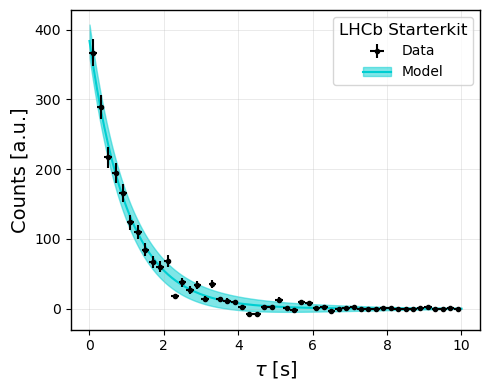

In [9]:
def eval_zfit_expo(par: float)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    with tau_sig.set_value(par):
        pdf = model_ltime.pdf(basis) * sum_sw_sig
    return pdf

# normalisation for plot
sum_sw_sig = data['sw_sig'].sum()

# get the model pdf for the plot
basis_tau = np.linspace(*obs_tau.limit1d, 200)
model_tau_np = model_ltime.pdf(basis_tau).numpy() * sum_sw_sig

# compute the uncertainties propagated to the model shape
rnd_pars = gen.normal(tau_sig.numpy(), result_ltime.params['tau_sig']['minuit_hesse']['error'], 200,)
smodels_tau_np = np.std([eval_zfit_expo(par) for par in rnd_pars], ddof=1, axis=0)

# plot the fit 
plot_fit(data['lifetime'], basis_tau, model_tau_np, obs_tau, 
         smodel=smodels_tau_np, weight=data['sw_sig'], xlabel=r'$\tau$ [s]')

We obtained the lifetime that we have generated within the uncertainties, but...

### Careful

Uncertainties of parameters determined by weighted fits are difficult to determine correctly, see [Langenbruch's paper](https://arxiv.org/pdf/1911.01303.pdf)

## Simultaneous Fits

Often a paper states that the measurement was performed using simultaneous fits. This can be useful if one observable can be inferred from multiple datasets, or a there is a connection between observables in the different datasets. 

Conceptually a simultaneous fit corresponds to multiplying the likelihoods of the different datasets, which translates to a sum of log likelihoods. 

In `zfit` a simultaneous fit is easy to set up, just by adding the cost functions. We will look at an example where a second sample is created with a smaller signal component (a "rare" data set), that makes the determination of the signal shape parameters more challenging. A simultaneous fit can be used to help to constrain those parameters from a control sample - our initial fit!

To summarize the illustration we suggest below, we have two datasets; our "original" dataset as fitted above, and our "rare" dataset with a smaller signal yield. The underlying idea is that we want the signal parameters (mu and sigma) to be shared amongst the original fit and the "rare" data fit, as they are described by the same physical principle. However, all the other parameters (in this case the background slope), should not be shared; the background in the original and the "rare" dataset do not necessarily have the same properties. Also the yields of both signal and background models should not be shared between the two datasets as they are also not necessarily the same.

In [10]:
# "rare" data sample with less events
# For signal: input parameters (mu, sigma) in the generator are the same as before - same underlying mechanism
# For data: input parameters (slope) in the generator are not necessarily the same as before - not the same underlying mechanism, background can look differently
# In both cases, the size can be different.
rare_signal = gen.normal(0.5, 0.1, size=(100,))
rare_bkg = gen.exponential(0.5, size=(400,))

# create the zfit data 
data_rare = np.append(rare_signal, rare_bkg)
data_rare = data_rare[data_rare<=1] # cut away tail
data_rare_zfit = zfit.Data.from_numpy(obs=obs, array=data_rare)

# parameters for the models for the "rare" fit
# note that we will take the mean and width for the
# signal shape from before, to have them shared in the
# simultaneous fit!
n_sig_rare = zfit.Parameter('n_sig_rare', 100, -100, 600)
n_bkg_rare = zfit.Parameter('n_bkg_rare', data_rare.shape[0]-100, 0, 600)

slope_rare = zfit.Parameter('slope_rare', -2, -10, 0)

# the signal and background models for the "rare" fit
signal_rare_ = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, name='signal_rare')
signal_rare = signal_rare_.create_extended(n_sig_rare)

bkg_rare_ = zfit.pdf.Exponential(obs=obs, lam=slope_rare, name='bkg_rare')
bkg_rare = bkg_rare_.create_extended(n_bkg_rare)

# total model for the rare fit
model_rare = zfit.pdf.SumPDF([signal_rare, bkg_rare])

# likelihood in the simultaneous fit. you can either create them individually
# and sum them up or create it from a list of models and data (and constraints)
nll_sim = zfit.loss.ExtendedUnbinnedNLL(model=[model_rare, model], data=[data_rare_zfit, data_zfit])

Performing the fit:

In [11]:
# minimise the likelihood and run hesse
result_sim = minimiser.minimize(nll_sim)
result_sim.hesse(name='minuit_hesse')
result_sim

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_4, Composed_autoparam_5], <zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.Data: Data obs=('mass',) shape=(435, 1)>, <zfit.Data: Data obs=('mass',) shape=(7492, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00035 │          -1420.97 |  10014.5 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    minuit_hesse    at limit
----------  ------------------  --------------  ----------
n_sig_rare             126.577     +/-      17      

Note that as set up, there is only one signal mu and sigma as it was shared for the original signal and the rare signal. All other parameters exist in duplicates for the original signal/data as they are not necessarily the same.

Plotting the fit output for the rare signal+data:

Histogram(Regular(25, 0, 1), storage=Double()) # Sum: 435.0

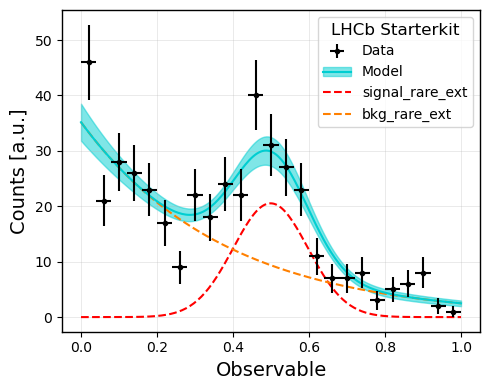

In [12]:
def eval_rare_zfit_model(model: zfit.pdf.BasePDF, basis:np.ndarray, 
                         pars: np.ndarray, zfit_pars: list)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    with zfit.param.set_values(zfit_pars, pars):
        pdf = model_rare.pdf(basis) * (n_sig_rare.numpy()+n_bkg_rare.numpy())
    return pdf

# get the model pdf for the plot
basis = np.linspace(*obs.limit1d, 200)
model_rare_np = model_rare.pdf(basis).numpy() * (n_sig_rare.numpy()+n_bkg_rare.numpy())

# compute the uncertainties propagated to the model shape
mean_params = [result_sim.params[p]['value'] for p in result_sim.params.keys()]
covariance = result_sim.covariance()
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)
zfit_pars = [p for p in result_sim.params.keys()]

smodel_rare_np = np.std([eval_rare_zfit_model(model_rare, basis, pars, zfit_pars) 
                         for pars in rnd_pars], ddof=1, axis=0)

# plot the fit 
plot_fit(data_rare, basis, model_rare_np, obs, smodel=smodel_rare_np, nbins=25, zmodel=model_rare)

## Disjoint Fit Ranges

Fitting a pdf to a disjoint fit range is another frequent application of fits, often used to determine background pollution in a blinded signal region. 

We can use the previous example of the rare dataset and try to estimate the yield of the background without unblinding the signal peak. 

In `zfit`, we need two observable spaces for this, which can be combined by adding them. 

In [13]:
# the two spaces for the "lower" and "upper" mass. 
# the areas are chosen to exclude the +/- 3 sigma 
# region of our signal shape
obs_lower = zfit.Space('Observable', limits=(0, 0.3)) 
obs_upper = zfit.Space('Observable', limits=(0.7, 1))

# combine the two spaces into one, which excludes the center area
obs_disjoint = obs_lower + obs_upper

# data over the disjoint space, note zfit will cut for us
data_rare_disjoint = zfit.Data.from_numpy(obs=obs_disjoint, array=data_rare)

# build parameters for the disjoint background model
slope_disjoint = zfit.Parameter('slope_disjoint', -2, -10, 0)
n_bkg_disjoint = zfit.Parameter('n_bkg_disjoint', 200, 0, 500)

# build the disjoint background model
bkg_disjoint_ = zfit.pdf.Exponential(obs=obs_disjoint, lam=slope_disjoint, name='bkg_disjoint')
bkg_disjoint = bkg_disjoint_.create_extended(n_bkg_disjoint)

# construct the cost function
nll_disjoint = zfit.loss.ExtendedUnbinnedNLL(model=bkg_disjoint, data=data_rare_disjoint)

/var/folders/23/5n_ndwdj5dq02zybdsm8cpkr0000gq/T/ipykernel_10734/590428170.py:8: DeprecationWarning: __add__ (from zfit.core.space) is deprecated and will be removed in a future version.
Instructions for updating:
Multiple limits won't be supported anymore in the future. For alternatives, see the announcement: https://github.com/zfit/zfit/discussions/533
  obs_disjoint = obs_lower + obs_upper


In [14]:
result_disjoint = minimiser.minimize(nll_disjoint)
result_disjoint.hesse(name='minuit_hesse')
print(result_disjoint)
print(f'\nCompare to simultaneous fit:')
print(f'slope = {result_sim.params[slope_rare]["value"]:.3f} +/- '+\
      f'{result_sim.params[slope_rare]["minuit_hesse"]["error"]:.3f}')
print(f'yield = {result_sim.params[n_bkg_rare]["value"]:.3f} +/- '+\
      f'{result_sim.params[n_bkg_rare]["minuit_hesse"]["error"]:.3f}')

/Users/vanlaak/miniconda3/envs/zfit_env/lib/python3.10/site-packages/zfit/core/integration.py:624: UserWarning: Multispace limits compare never equal to Space.
  limits_matched = [lim for lim, integ in self._integrals[axes].items() if integ.limits >= limits]


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.basic.Exponential'>  params=[slope_disjoint, slope_disjoint]] data=[<zfit.Data: Data obs=('Observable',) shape=(219, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 8.2e-06 │          -172.39 |  10048.11 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name              value  (rounded)    minuit_hesse    at limit
--------------  ------------------  --------------  ----------
n_bkg_disjoint             218.963     +/-      15       False
slope_disjoint            -2.47528     +/-    0.26       False

Compare to simultaneous fit:
slope = -2.651 +/- 0.270
yield = 308.

The yield is considerably smaller than in the fit to whole observable range, this is because the **normalisation range** is different. If we want to compare the yield over the whole range, we need to add the missing region from $[0.3 - 0.7]$:

In [15]:
# when performing integrals in zfit, you need to specify a range, using a zfit.Space object, or a tuple
limits_fitted = obs_disjoint
limits_partial = zfit.Space('Observable', limits=(0.3, 0.7))
limits_partial = (0.3, 0.7) # ^ both options work
total_area = bkg_disjoint.integrate(limits=obs_disjoint).numpy().item() # area under the fit over the whole defined space
partial_area = bkg_disjoint.integrate(limits=limits_partial).numpy().item() # area under the fit over the intermediate (blinded) region

n_bkg_scaled = (partial_area+total_area) / total_area * n_bkg_disjoint.numpy()
print(f'Background yield scaled to full range: {n_bkg_scaled:.1f}')
print(f'Background yield from sim. fit: {n_bkg_rare.numpy():.1f}')


Background yield scaled to full range: 325.1
Background yield from sim. fit: 308.3


As we can see, there are differences between our extrapolation and the fit to the full range, but this is to be expected given the slightly different slopes of the exponential. Lets visualise the disjoint fit:

Histogram(Regular(50, 0, 1), storage=Double()) # Sum: 219.0

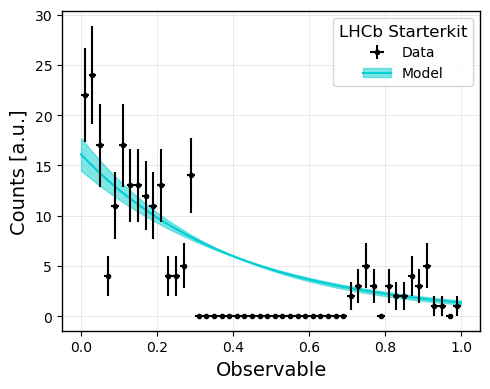

In [16]:
# the model pdf
model_dis_np = stats.expon.pdf(basis, loc=0, scale=-1/(slope_disjoint.numpy())) * n_bkg_scaled
lams = gen.normal(result_disjoint.params[slope_disjoint]['value'], 
                  result_disjoint.params[slope_disjoint]['minuit_hesse']['error'], 200)
smodel_dis_np = np.std([stats.expon.pdf(basis, loc=0, scale=-1/lam) * n_bkg_scaled 
                        for lam in lams], ddof=1, axis=0)

# plot the fit, you can get creative here
plot_fit(data_rare_disjoint.numpy().flatten(), basis, model_dis_np, obs, smodel=smodel_dis_np)

## Custom PDFs

In some cases, the pdf that you require to model your data may not be implemented in `zfit`. 
In this case, it is possible to add a custom pdf by yourself, which you can do the following way:
(See also the [`zfit` tutorial](https://zfit.readthedocs.io/en/latest/_tmp/zfit-tutorials/components/60%20-%20Custom%20PDF.html)). Some more pdfs for physics use cases are also found at [`zfit-physics`](https://github.com/zfit/zfit-physics). 

In [17]:
from zfit.pdf import ZPDF
from zfit import z
from tensorflow_probability import distributions as tfd

class JohnsonSU(ZPDF):
    """ Johnson SU pdf """
    _N_OBS = 1
    _PARAMS = ['skewness', 'tailweight', 'mu', 'sigma']
    
    def _unnormalized_pdf(self, x):
        x = x.unstack_x(x)
        skew = self.params['skewness']
        tail = self.params['tailweight']
        mu = self.params['mu']
        sigma = self.params['sigma']

        dist = tfd.JohnsonSU(skewness=skew, tailweight=tail, loc=mu, scale=sigma)
        return dist.prob(value=x, name="unnormalised_pdf")

skew = zfit.Parameter('skew', 1, 0, 2)
tail = zfit.Parameter('tail', 1, 0, 2)
mu_john = zfit.Parameter('mu_john', 0.5, 0, 1)
sigma_john = zfit.Parameter('sigma_john', 0.1, 1e-4, 1)

my_pdf = JohnsonSU(obs=obs, skewness=skew, tailweight=tail, mu=mu, sigma=sigma)
print(my_pdf.pdf(np.linspace(0,1,10)).numpy())

[[3.58685155e-01 6.12825734e-01 1.12357567e+00 2.18700505e+00
  3.49974094e+00 1.17013087e+00 1.59393966e-01 3.25528140e-02
  9.35256992e-03 3.35973111e-03]]


## Visualising Fit Quality with Pulls

When presenting fit results, it's important to visualise how well the model describes the data. A **pulls plot** is a powerful tool for this purpose. 

A pull is defined as:
$$ \text{pull}_i = \frac{n_i^{\text{data}} - n_i^{\text{fit}}}{\sigma_i} $$

where $n_i^{\text{data}}$ is the number of observed events in bin $i$, $n_i^{\text{fit}}$ is the expected number from the fit, and $\sigma_i$ is the uncertainty on the data (typically $\sqrt{n_i^{\text{data}}}$ for counting statistics).

**Why pulls are useful:**
- If the model describes the data well, pulls should be centered around 0
- Pulls should be randomly distributed with a standard deviation of ~1
- Systematic deviations indicate potential model misspecification
- They make small discrepancies more visible than just looking at the data/model overlay

**How to create a pulls plot:**

We can create two subplots in `matplotlib` using `GridSpec` that share the x-axis, then use `plot_fit` on the top subplot and manually create the pulls on the bottom. The `plot_fit` function accepts an optional `ax` parameter and returns the histogram, making it easy to calculate pulls.

(-3.8919940397389454, 3.8919940397389454)

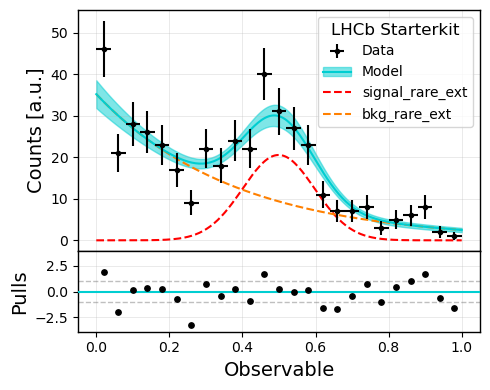

In [18]:
import boost_histogram as bh
from matplotlib.gridspec import GridSpec

# Create a figure with two subplots sharing the x-axis
fig = plt.figure()
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.0, figure=fig)
ax_main = fig.add_subplot(gs[0])
ax_pulls = fig.add_subplot(gs[1], sharex=ax_main)

# Plot the fit on the main axis using plot_fit
# We pass ax=ax_main so it plots on our subplot
hist = plot_fit(data_rare, basis, model_rare_np, obs, smodel=smodel_rare_np, 
                nbins=25, zmodel=model_rare, xlabel=None, 
                ax=ax_main)

# Hide x-tick labels on main plot since x-axis is shared
ax_main.tick_params(labelbottom=False)

# Now create the pulls plot on the lower subplot
# Get the histogram data for pulls calculation
area = obs.area().numpy()
nbins = 25

# Calculate error bars (Poisson statistics)
yerr = np.ones_like(hist.values())
yerr[hist.values()>=0] = np.sqrt(hist.values()[hist.values()>=0])

# Evaluate model at bin centers
y_model_centers = np.interp(hist.axes.centers[0], basis, model_rare_np * area/nbins)

# Calculate pulls: (data - model) / error
pulls = (hist.values() - y_model_centers) / yerr

# Plot the pulls
ax_pulls.scatter(hist.axes.centers[0], pulls, c='black', s=15, zorder=10)
ax_pulls.axhline(0, color='darkturquoise', linestyle='-', linewidth=1.5, zorder=8)
ax_pulls.axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax_pulls.axhline(-1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Labels and formatting
ax_main.tick_params(labelbottom=False)  # Hide x-tick labels on main plot
ax_pulls.set_xlabel('Observable')
ax_pulls.set_ylabel('Pulls')

# Set symmetric y-limits for pulls
max_pull = max(abs(np.nanmin(pulls)), abs(np.nanmax(pulls)))
ax_pulls.set_ylim(-max_pull * 1.2, max_pull * 1.2)


### Interpreting the Pulls Plot

**What to look for:**
- **Random scatter around 0**: Indicates the model describes the data well
- **Values within ±1σ**: Most pulls (about 68%) should fall in this range for a good fit
- **Systematic trends**: If pulls consistently deviate in one direction, the model may be biased
- **Outliers beyond ±3σ**: A few are expected, but many suggest poor fit quality

The pulls plot above shows the residuals normalised by their uncertainties, making it easy to spot whether discrepancies between data and model are statistically significant or just statistical fluctuations.

## Recap

Explored some more advanced applications to fits with `zfit` including:
 - Pseudoexperiments and how to set them up
 - Background subtraction and what to do with it
 - Simultaneous fits and sharing parameters
 - Disjoint fit ranges and normalisation ranges (and how to integrate a fit model)
 - Creating custom PDFs
 - Creating a pulls plot